In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import saqqara
import sys
sys.path.insert(0, '../inference/')
sys.path.insert(0, '../simulator/')
from networks import SignalAET
from simulator import LISA_AET
from dataloader import get_datasets, setup_dataloaders, get_data_npy_dataset
import numpy as np
import torch
import matplotlib.pyplot as plt
import glob
import pickle
import swyft
import logging
log = logging.getLogger("pytorch_lightning")
log.propagate = False
log.setLevel(logging.ERROR)


/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
config = glob.glob(f"../configs/bounded_R2_cosine.yaml")[0]
settings = saqqara.load_settings(config_path=config)
sim = LISA_AET(settings)

Detector setup complete
Noise matrices computed
Response computed
Coarse graining setup complete


In [29]:
data_sample = sim.sample(conditions={"z": np.array([-11.0, 0.0, 3.0, 15.0])})

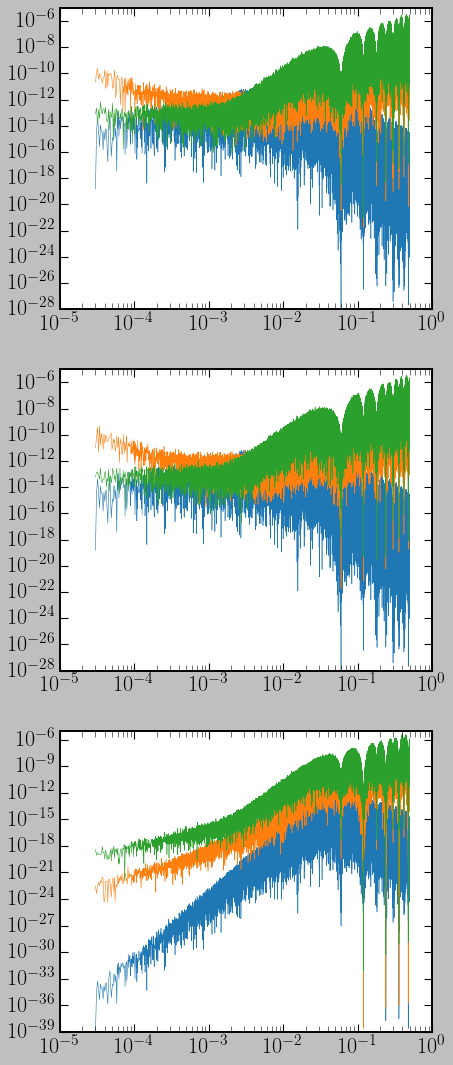

In [30]:
fig = plt.figure(figsize=(6, 16))
for channel in range(3):
    ax = plt.subplot(3, 1, channel + 1)    
    plt.loglog(sim.f_vec, np.abs(data_sample['linear_signal_AET'][:, channel])**2, c='C0', lw=0.5)
    plt.loglog(sim.f_vec, np.abs(data_sample['linear_TM_noise_AET'][:, channel])**2, c='C1', lw=0.5)
    plt.loglog(sim.f_vec, np.abs(data_sample['linear_OMS_noise_AET'][:, channel])**2, c='C2', lw=0.5)

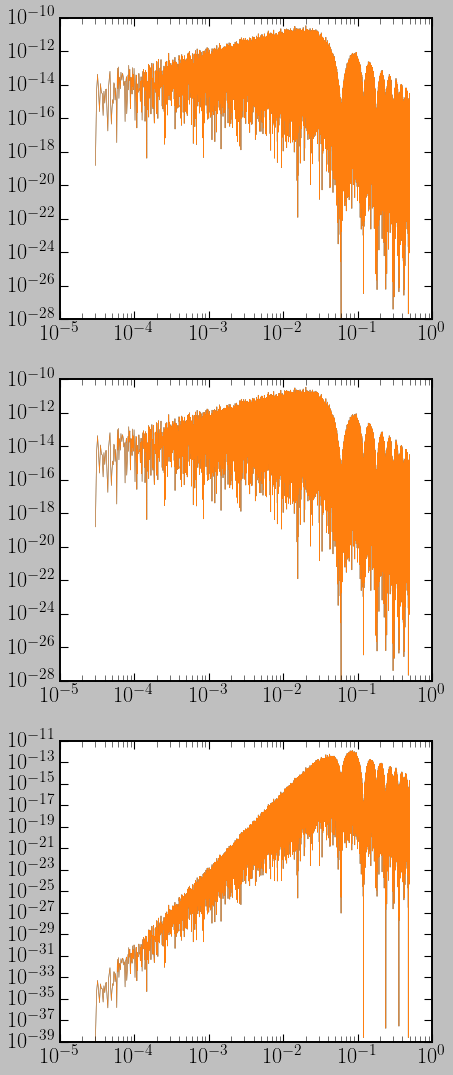

In [31]:
fig = plt.figure(figsize=(6, 16))
for channel in range(3):
    ax = plt.subplot(3, 1, channel + 1)    
    plt.loglog(sim.f_vec, np.abs(data_sample['linear_signal_AET'][:, channel])**2, c='C0', lw=0.5)
    plt.loglog(sim.f_vec, data_sample['quadratic_signal_AET'][:, channel], c='C1', lw=0.5)

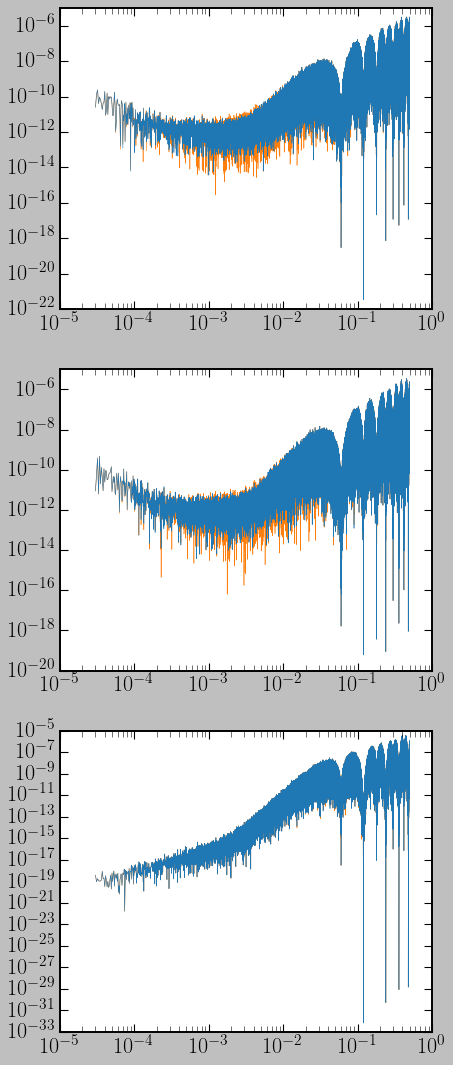

In [32]:
fig = plt.figure(figsize=(6, 16))
for channel in range(3):
    ax = plt.subplot(3, 1, channel + 1)    
    plt.loglog(sim.f_vec, data_sample['quadratic_data_AET'][:, channel], c='C0', lw=0.5)
    plt.loglog(sim.f_vec, data_sample['full_quadratic_data_AET'][:, channel], c='C1', lw=0.5, zorder=-10)

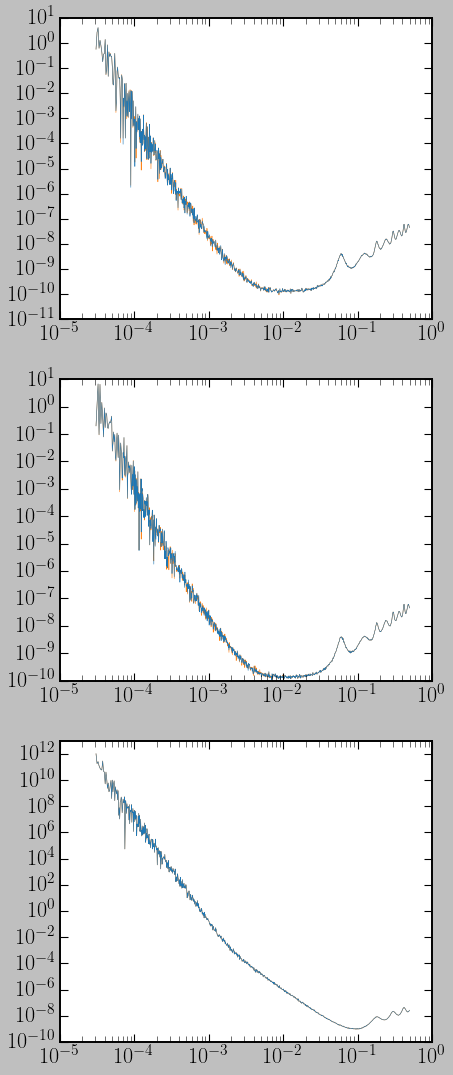

In [33]:
fig = plt.figure(figsize=(6, 16))
for channel in range(3):
    ax = plt.subplot(3, 1, channel + 1)    
    plt.loglog(sim.coarse_grained_f, data_sample['coarse_grained_data'][:, channel], c='C0', lw=0.5)
    plt.loglog(sim.coarse_grained_f, data_sample['full_coarse_grained_data'][:, channel], c='C1', lw=0.5, zorder=-10)

In [34]:
cg_tm_data = sim.generate_coarse_grained_data_from_sum(
    sim.generate_quadratic_data(data_sample["linear_TM_noise_AET"])
)
cg_oms_data = sim.generate_coarse_grained_data_from_sum(
    sim.generate_quadratic_data(data_sample["linear_OMS_noise_AET"])
)
cg_signal_data = sim.generate_coarse_grained_data_from_sum(
    sim.generate_quadratic_data(data_sample["linear_signal_AET"])
)
cg_tm_oms_cross_data = sim.generate_coarse_grained_data_from_sum(
    2
    * np.real(
        np.einsum(
            "...i,...i->...i",
            data_sample["linear_TM_noise_AET"],
            np.conj(data_sample["linear_OMS_noise_AET"]),
        )
    )
)
cg_tm_signal_cross_data = sim.generate_coarse_grained_data_from_sum(
    2
    * np.real(
        np.einsum(
            "...i,...i->...i",
            data_sample["linear_TM_noise_AET"],
            np.conj(data_sample["linear_signal_AET"]),
        )
    )
)
cg_oms_signal_cross_data = sim.generate_coarse_grained_data_from_sum(
    2
    * np.real(
        np.einsum(
            "...i,...i->...i",
            data_sample["linear_OMS_noise_AET"],
            np.conj(data_sample["linear_signal_AET"]),
        )
    )
)

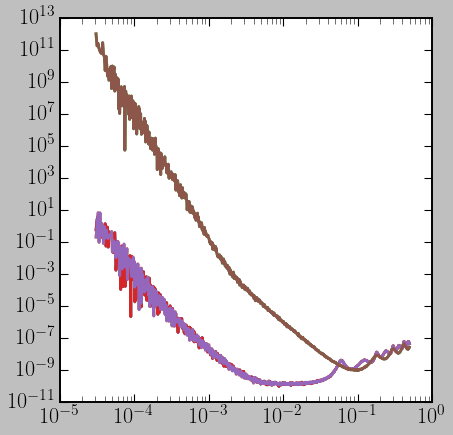

In [37]:
plt.loglog(sim.coarse_grained_f, cg_tm_data + cg_oms_data + cg_signal_data + cg_tm_oms_cross_data + cg_tm_signal_cross_data + cg_oms_signal_cross_data)
plt.loglog(sim.coarse_grained_f, data_sample['full_coarse_grained_data'])

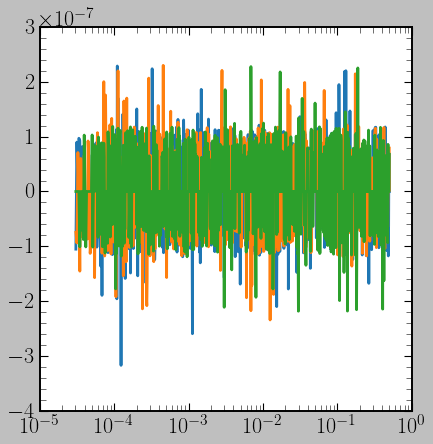

In [41]:
plt.semilogx(sim.coarse_grained_f, (cg_tm_data + cg_oms_data + cg_signal_data + cg_tm_oms_cross_data + cg_tm_signal_cross_data + cg_oms_signal_cross_data - data_sample['full_coarse_grained_data']) / data_sample['full_coarse_grained_data'])

In [65]:
arr = np.load("../resampling_data_with_signal/cg_data_B2A0VZ.npy")[10]

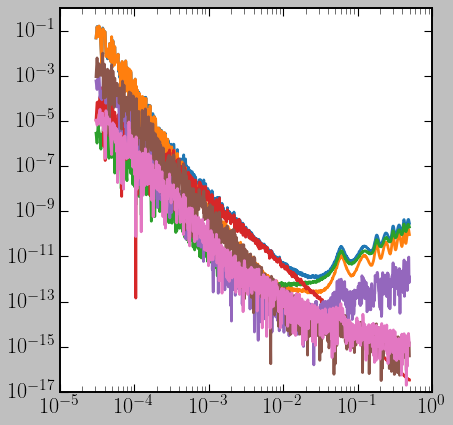

In [64]:
plt.loglog(sim.coarse_grained_f, np.sum(arr[0, :, :, 0], axis=0))
for i in range(6): plt.loglog(sim.coarse_grained_f, np.abs(arr[0, i, :, 0]))

In [68]:
import glob

In [73]:
npy_files = glob.glob("../resampling_data_with_signal/cg_data_*.npy")

In [79]:
npy_dataset = saqqara.NPYDataset(npy_files)
resampling_dataset = saqqara.RandomSamplingDataset(npy_dataset)

In [104]:
arr = resampling_dataset[0:10]

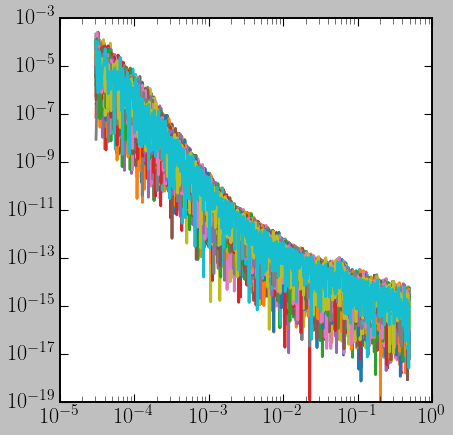

In [103]:
arr = resampling_dataset[0]
for k in ['oms_signal_cross']:
    for _ in range(100):
        arr = resampling_dataset[0]
        plt.loglog(sim.coarse_grained_f, np.abs(arr[k][:, 0]))

In [133]:
training_dataset = saqqara.ResamplingTraining(sim, resampling_dataset)

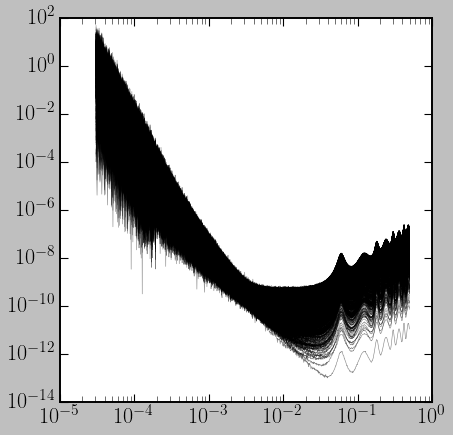

In [134]:
for _ in range(1000):
    arr = training_dataset[0]
    plt.loglog(sim.coarse_grained_f, arr['data'][:, 0], c='k', lw=0.5, alpha=0.5)

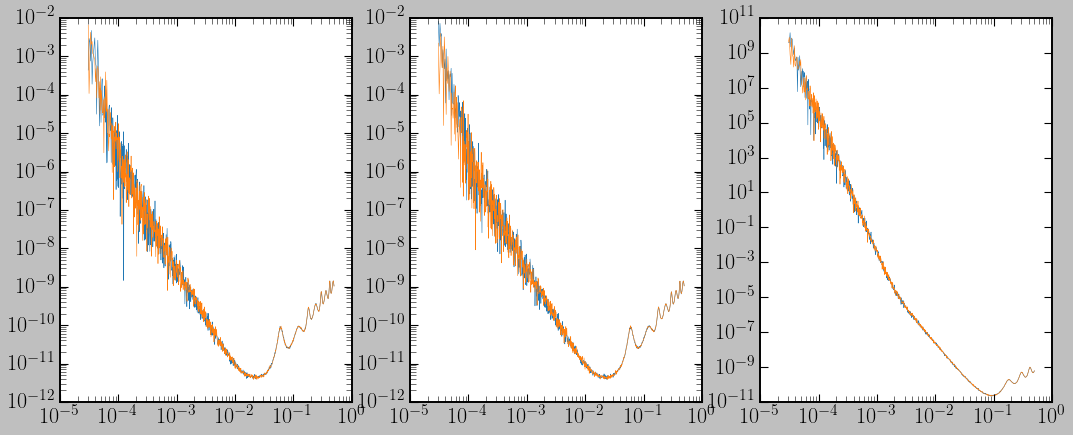

In [141]:
z = sim.prior.sample()
arr = training_dataset.sample(z=z)
arr_no_cross = training_dataset.sample(z=z, cross=0.0)
true_sample = sim.sample(conditions={"z": z})
fig = plt.figure(figsize=(16, 6))
for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    #plt.loglog(sim.coarse_grained_f, true_sample["full_coarse_grained_data"][:, i], lw=0.5)
    plt.loglog(sim.coarse_grained_f, arr['data'][:, i], lw=0.5)
    plt.loglog(sim.coarse_grained_f, arr_no_cross['data'][:, i], lw=0.5)

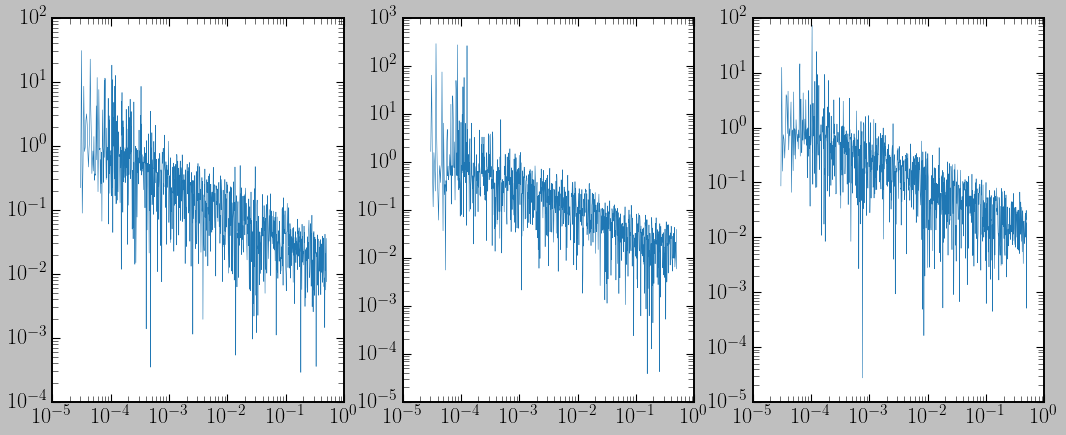

In [146]:
z = sim.prior.sample()
arr = training_dataset.sample(z=z)
arr_no_cross = training_dataset.sample(z=z, cross=0.0)
true_sample = sim.sample(conditions={"z": z})
fig = plt.figure(figsize=(16, 6))
for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    #plt.loglog(sim.coarse_grained_f, true_sample["full_coarse_grained_data"][:, i], lw=0.5)
    plt.loglog(sim.coarse_grained_f, np.abs(arr['data'][:, i] - arr_no_cross['data'][:, i]) / arr['data'][:, i], lw=0.5)